In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score

from collections import Counter
from sklearn.model_selection import train_test_split

import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import random
import time
import datetime

In [ ]:
train = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Github/UOS_NLP/ratings_train.txt')
test = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Github/UOS_NLP/ratings_test.txt')

In [ ]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (150000, 3) 
test shape => (50000, 3)


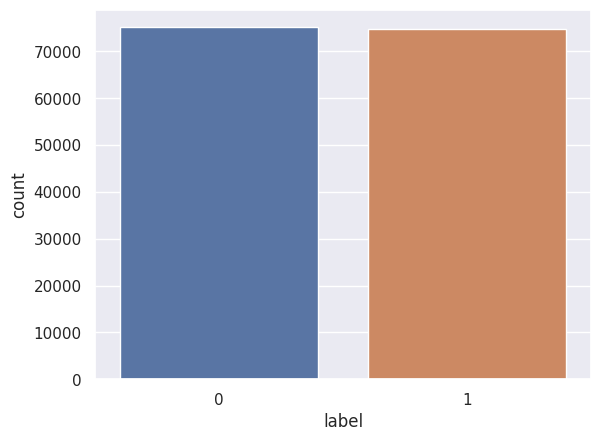

In [ ]:
sns.set_theme(style = "darkgrid")
ax = sns.countplot(x= "label", data = train)

In [ ]:
print(train['document'].nunique())
print(train['label'].nunique())

146182
2


In [ ]:
train.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
print(train.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [ ]:
train = train.dropna(how = 'any')
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['document'] = train['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train['document'].replace('', np.nan, inplace=True)
train = train.dropna(how = 'any')

<ipython-input-12-e4d562bf50eb>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-12-e4d562bf50eb>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [ ]:
test.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['document'] = test['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거

<ipython-input-13-af51f3160773>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-13-af51f3160773>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [ ]:
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla V100-SXM2-16GB


In [ ]:
train.shape

(145393, 3)

In [ ]:
train.document

0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 145393, dtype: object

In [ ]:
sentences = ["[CLS] " + str(s) + " [SEP]" for s in train.document]

In [ ]:
sentences[:5]

['[CLS] 아 더빙 진짜 짜증나네요 목소리 [SEP]',
 '[CLS] 흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나 [SEP]',
 '[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]',
 '[CLS] 교도소 이야기구먼 솔직히 재미는 없다평점 조정 [SEP]',
 '[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]']

In [ ]:
labels = train['label'].values

In [ ]:
sentences[5]

'[CLS] 막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움 [SEP]'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in sentences]
print(tokenized_texts[5])

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

['[CLS]', '막', '걸', '##음', '##마', '[UNK]', '세', '##부터', '초', '##등학교', '학', '##년', '##생', '##인', '[UNK]', '아', '##까', '##움', '[SEP]']


In [ ]:

MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9519,   9074, 119005,   9708, 119235,   9715, 119230,
        16439,  77884,  48549,   9284,  22333,  12692,    102,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, labels, stratify= labels, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=42,
                                                       test_size=0.1)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [ ]:
sentences = test['document']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
# 옵티마이저 설정
#경사하강법에서 변형된 여러 종류 중 하나인 Adamw 옵티마이저 적
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# 학습률을 점차 감소시키며 적용하는 방식
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 정확도 계산 함수
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    return accuracy

def calculate_f1_score (preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    f1 = f1_score(pred_flat, labels_flat, average='binary')
    return f1

def calculate_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    pre_score = precision_score(pred_flat, labels_flat, average='binary')
    return pre_score

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 재현을 위해 랜덤시드 고정, 42가 일반적
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    #train data 학습

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # train모드로 전환하는 함수 호출
    model.train()

    # 데이터로더에서 배치 사이즈 만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 작업(모델에 배치에서 추출한 data 적용)
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # transformers 라이브러리의 [0]은 loss를 나타냄
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()


        # Gradient clipping 적용(기울기값이 임계값 넘어갈 시 clipping해줌)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    #validation에 대해 학습

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변환하는 함수 호출
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy, eval_f1, eval_precision = 0, 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 평가모드에선 그래디언트 계산 x
        with torch.no_grad():
            # Forward 수행
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # 로스 구함
        logits = outputs[0]


        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = calculate_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        tmp_eval_f1 = calculate_f1_score(logits, label_ids)
        eval_f1 += tmp_eval_f1
        tmp_eval_precision = calculate_precision(logits, label_ids)
        eval_precision += tmp_eval_precision
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  F1 Score: {0:.2f}".format(eval_f1/nb_eval_steps))
    print("  Precision: {0:.2f}".format(eval_precision/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")



======== Epoch 1 / 4 ========
Training...
  Batch   500  of  4,090.    Elapsed: 0:01:45.
  Batch 1,000  of  4,090.    Elapsed: 0:03:30.
  Batch 1,500  of  4,090.    Elapsed: 0:05:15.
  Batch 2,000  of  4,090.    Elapsed: 0:07:01.
  Batch 2,500  of  4,090.    Elapsed: 0:08:46.
  Batch 3,000  of  4,090.    Elapsed: 0:10:31.
  Batch 3,500  of  4,090.    Elapsed: 0:12:16.
  Batch 4,000  of  4,090.    Elapsed: 0:14:02.

  Average training loss: 0.49
  Training epcoh took: 0:14:20

Running Validation...
  Accuracy: 0.79
  F1 Score: 0.79
  Precision: 0.78
  Validation took: 0:00:31

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  4,090.    Elapsed: 0:01:45.
  Batch 1,000  of  4,090.    Elapsed: 0:03:30.
  Batch 1,500  of  4,090.    Elapsed: 0:05:16.
  Batch 2,000  of  4,090.    Elapsed: 0:07:01.
  Batch 2,500  of  4,090.    Elapsed: 0:08:46.
  Batch 3,000  of  4,090.    Elapsed: 0:10:31.
  Batch 3,500  of  4,090.    Elapsed: 0:12:17.
  Batch 4,000  of  4,090.    Elapsed: 0:14:02

In [ ]:

#시작 시간 설정
t0 = time.time()
# 평가모드로 전환하는 함수 호출
model.eval()

# 변수 초기화
eval_loss, eval_accuracy , eval_f1, eval_precision= 0, 0, 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출/
    # 그래디언트 계산 안함(평가모드)
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = calculate_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    tmp_eval_f1 = calculate_f1_score(logits, label_ids)
    eval_f1 += tmp_eval_f1
    tmp_eval_precision = calculate_precision(logits, label_ids)
    eval_precision += tmp_eval_precision
    nb_eval_steps += 1


print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  F1 Score: {0:.2f}".format(eval_f1/nb_eval_steps))
print("  Precision: {0:.2f}".format(eval_precision/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


  Batch   100  of  1,527.    Elapsed: 0:00:03.
  Batch   200  of  1,527.    Elapsed: 0:00:06.
  Batch   300  of  1,527.    Elapsed: 0:00:08.
  Batch   400  of  1,527.    Elapsed: 0:00:11.
  Batch   500  of  1,527.    Elapsed: 0:00:14.
  Batch   600  of  1,527.    Elapsed: 0:00:17.
  Batch   700  of  1,527.    Elapsed: 0:00:19.
  Batch   800  of  1,527.    Elapsed: 0:00:22.
  Batch   900  of  1,527.    Elapsed: 0:00:25.
  Batch 1,000  of  1,527.    Elapsed: 0:00:28.
  Batch 1,100  of  1,527.    Elapsed: 0:00:31.
  Batch 1,200  of  1,527.    Elapsed: 0:00:33.
  Batch 1,300  of  1,527.    Elapsed: 0:00:36.
  Batch 1,400  of  1,527.    Elapsed: 0:00:39.
  Batch 1,500  of  1,527.    Elapsed: 0:00:42.

Accuracy: 0.83
  F1 Score: 0.80
  Precision: 0.80
Test took: 0:00:42


In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/model/movie_sentiment_model')
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/tokenizer/movie_sentiment_tokenizer')

('/content/drive/MyDrive/Colab Notebooks/tokenizer/movie_sentiment_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/tokenizer/movie_sentiment_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/tokenizer/movie_sentiment_tokenizer/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/tokenizer/movie_sentiment_tokenizer/added_tokens.json')

In [ ]:
# Google Drive 경로에서 모델 및 토크나이저 로드
loaded_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/model/movie_sentiment_model')
loaded_tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/tokenizer/movie_sentiment_tokenizer')



In [ ]:
# 예측할 텍스트 입력
text_to_predict = "장점: 배우들의 연기가 좋다. 단점: 너무 뻔한 스토리"

# 텍스트를 토큰화하고 모델 입력 형식으로 변환
inputs = loaded_tokenizer(text_to_predict, return_tensors="pt")

# 모델에 입력 전달하여 예측
outputs = loaded_model(**inputs)

# 로드된 모델의 출력 중 예측값 추출
predictions = torch.argmax(outputs.logits, dim=1).item()

print("Predicted class:", predictions)


Predicted class: 0
